<a href="https://colab.research.google.com/github/estebansalas18/clasificador-imagenes/blob/main/clasificador_de_vehiculos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Input, MaxPooling2D, Activation
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint
#from keras.utils import np_utils
import numpy as np
from keras.utils import to_categorical
import os
import numpy as np
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import random
import shutil
import os
from keras.preprocessing.image import ImageDataGenerator

In [13]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
classes = ['Angus', 'Beefmaster', 'Bison', 'Brahman', 'Charolais', 'Guzerat', 'Holstein', 'Simmental']
n_classes = len(classes)

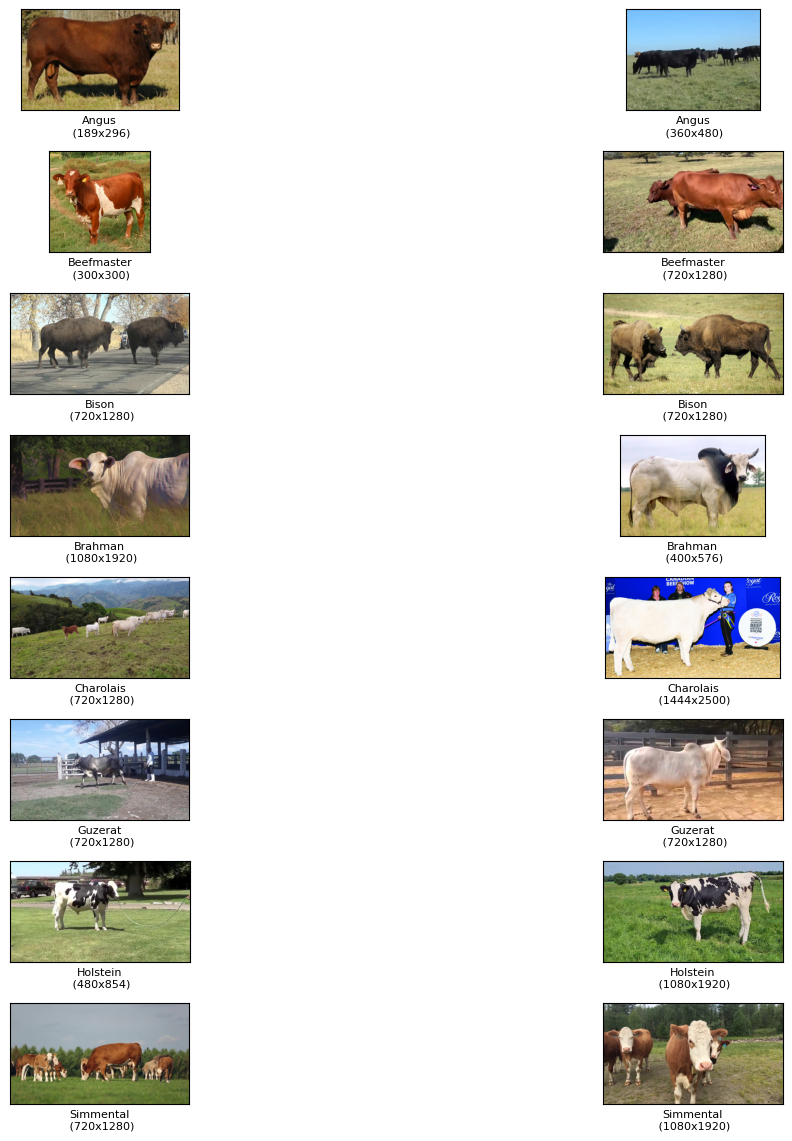

In [14]:
#Showing radom images from each class in dataset
plt.figure(figsize=(12, 24))  # Ajusta el tamaño de la figura según sea necesario
count = 0
for i, cls in enumerate(classes):
    for j in range(2):
        dir = f'/content/drive/MyDrive/Bovine cattle images/{cls}'
        filename = random.choice(os.listdir(dir))
        path = os.path.join(dir, filename)
        img = plt.imread(path)
        count += 1

        # Añade espacio entre los subgráficos para el texto
        plt.subplot(17, 2, count)
        plt.subplots_adjust(hspace=0.5)  # Ajusta el espacio vertical entre subgráficos

        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(img)
        plt.xlabel(f'{cls}\n ({img.shape[0]}x{img.shape[1]})', fontsize=8, ha='center')

plt.tight_layout(pad=1.0)  # Ajusta el espacio entre subgráficos
plt.show()


In [15]:
#Load and transform images in tensorflow

datagen = ImageDataGenerator(
    validation_split=0.2,
    rescale=1./255,
  )

train_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/Bovine cattle images',
    target_size=(64, 64),
    batch_size=32,seed=123,
    subset='training',
    color_mode="rgb",
    class_mode='sparse',
    classes=classes
)
valid_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/Bovine cattle images',
    target_size=(64, 64),
    batch_size=32,seed=123,
    subset='validation',
    class_mode='sparse',
    color_mode="rgb",
    classes=classes
)

Found 6400 images belonging to 8 classes.
Found 1600 images belonging to 8 classes.


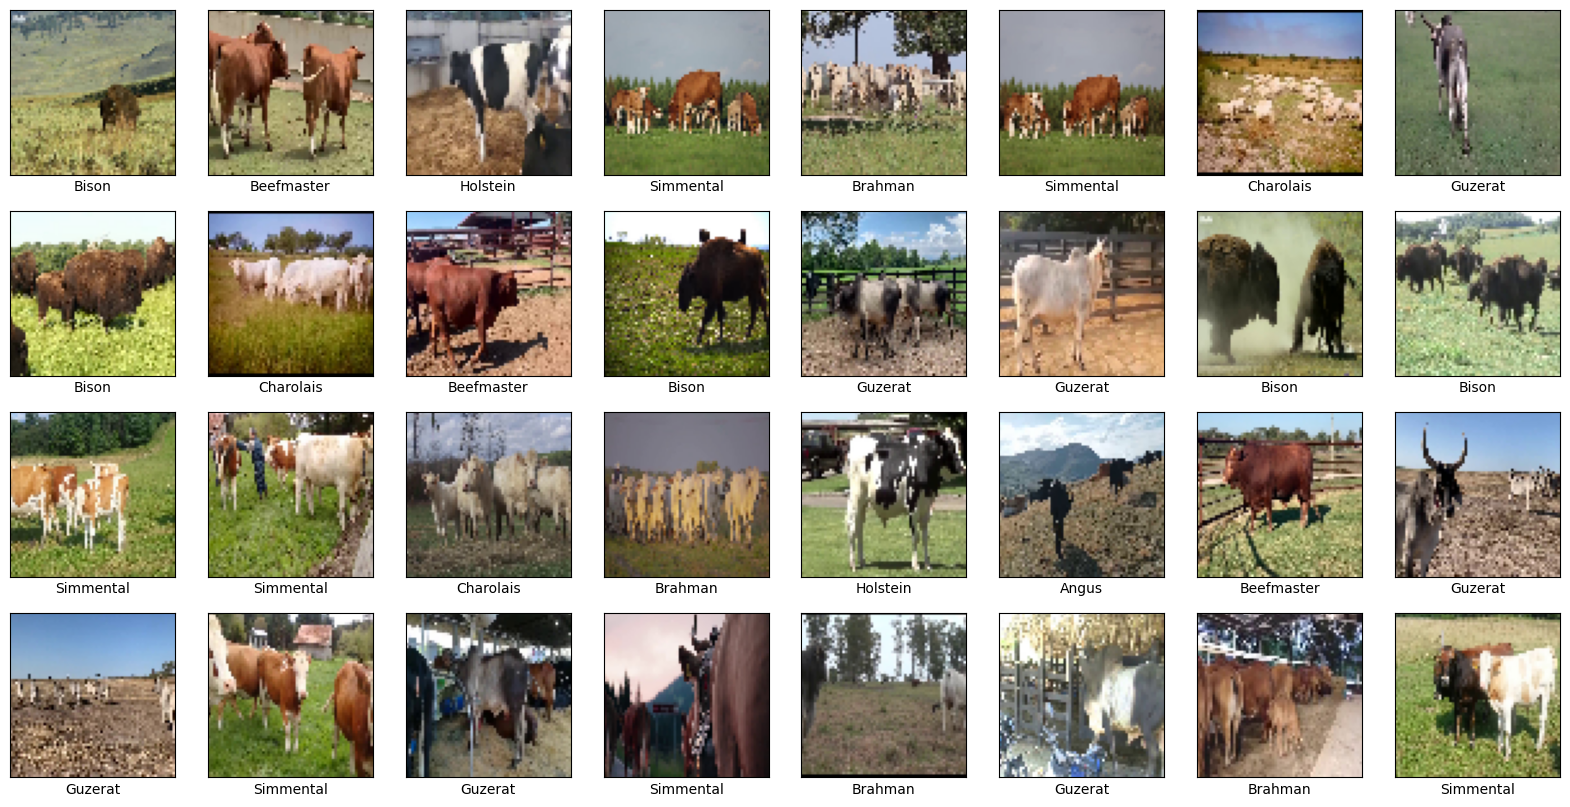

In [16]:
#showing images after transformations

import numpy as np
fig = plt.figure(figsize=(20,10))
imgs,lbls = train_generator.next()
for i in range(0,32):
  plt.subplot(4,8,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(imgs[i].reshape((64,64, 3)), cmap='gray')
  plt.xlabel(classes[int(lbls[i])])
plt.show()

In [17]:
#Compute Class weights
from sklearn.utils.class_weight import compute_class_weight
class_weight = compute_class_weight('balanced', classes=range(n_classes), y=valid_generator.labels.astype(int))
class_weight = dict(zip(range(len(class_weight)), class_weight))
class_weight

{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0}

In [20]:
#defining metrics

from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# from sklearn.metrics import multilabel_confusion_matrix
def conf_matrix_m(y_true, y_pred):
  return tf.math.confusion_matrix(y_true, K.argmax(y_pred), num_classes=n_classes)

In [21]:
# CNN model

model = Sequential()

#### Input Layer ####
model.add(Conv2D(filters=16, kernel_size=(3,3), padding='same',
                 activation='relu', input_shape=(64, 64, 3)))

#### Convolutional Layers ####
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))  # Pooling
model.add(Dropout(0.3)) # Dropout

model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, (5,5), padding='same', activation='relu'))
model.add(Conv2D(128, (5,5), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

#### Fully-Connected Layer ####
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(n_classes, activation='softmax'))

# model.summary()
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer="Nadam",
              metrics=['accuracy', f1_m, conf_matrix_m, precision_m, recall_m ]
              )


In [22]:
#Train the model
history =model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=20,
                    validation_data=valid_generator,
                    validation_steps = len(valid_generator),
                    class_weight=class_weight,
                  )

Epoch 1/20
200/200 [==============================] - 1207s 6s/step - loss: 1.3509 - accuracy: 0.5080 - f1_m: 3.2965 - conf_matrix_m: 0.5000 - precision_m: 3250002.5000 - recall_m: 2.3482 - val_loss: 4.1544 - val_accuracy: 0.1250 - val_f1_m: 1.3756 - val_conf_matrix_m: 0.5000 - val_precision_m: 1.3345 - val_recall_m: 1.4248
Epoch 2/20
200/200 [==============================] - 95s 475ms/step - loss: 0.6605 - accuracy: 0.7814 - f1_m: 1.5872 - conf_matrix_m: 0.5000 - precision_m: 1.6295 - recall_m: 1.5566 - val_loss: 2.9432 - val_accuracy: 0.2912 - val_f1_m: 2.1804 - val_conf_matrix_m: 0.5000 - val_precision_m: 2.5177 - val_recall_m: 1.9359
Epoch 3/20
200/200 [==============================] - 93s 468ms/step - loss: 0.4271 - accuracy: 0.8589 - f1_m: 1.2807 - conf_matrix_m: 0.5000 - precision_m: 1.2501 - recall_m: 1.3179 - val_loss: 2.3893 - val_accuracy: 0.4606 - val_f1_m: 1.5344 - val_conf_matrix_m: 0.5000 - val_precision_m: 1.5247 - val_recall_m: 1.5530
Epoch 4/20
200/200 [============

Epoch 1/20

```
Epoch 1/20
200/200 [==============================] - 1207s 6s/step - loss: 1.3509 - accuracy: 0.5080 - f1_m: 3.2965 - conf_matrix_m: 0.5000 - precision_m: 3250002.5000 - recall_m: 2.3482 - val_loss: 4.1544 - val_accuracy: 0.1250 - val_f1_m: 1.3756 - val_conf_matrix_m: 0.5000 - val_precision_m: 1.3345 - val_recall_m: 1.4248
Epoch 2/20
200/200 [==============================] - 95s 475ms/step - loss: 0.6605 - accuracy: 0.7814 - f1_m: 1.5872 - conf_matrix_m: 0.5000 - precision_m: 1.6295 - recall_m: 1.5566 - val_loss: 2.9432 - val_accuracy: 0.2912 - val_f1_m: 2.1804 - val_conf_matrix_m: 0.5000 - val_precision_m: 2.5177 - val_recall_m: 1.9359
Epoch 3/20
200/200 [==============================] - 93s 468ms/step - loss: 0.4271 - accuracy: 0.8589 - f1_m: 1.2807 - conf_matrix_m: 0.5000 - precision_m: 1.2501 - recall_m: 1.3179 - val_loss: 2.3893 - val_accuracy: 0.4606 - val_f1_m: 1.5344 - val_conf_matrix_m: 0.5000 - val_precision_m: 1.5247 - val_recall_m: 1.5530
Epoch 4/20
200/200 [==============================] - 97s 486ms/step - loss: 0.3350 - accuracy: 0.8900 - f1_m: 1.1821 - conf_matrix_m: 0.5000 - precision_m: 1.1372 - recall_m: 1.2338 - val_loss: 2.3004 - val_accuracy: 0.5219 - val_f1_m: 1.3851 - val_conf_matrix_m: 0.5000 - val_precision_m: 1.3662 - val_recall_m: 1.4120
Epoch 5/20
200/200 [==============================] - 95s 477ms/step - loss: 0.2418 - accuracy: 0.9214 - f1_m: 1.1028 - conf_matrix_m: 0.5000 - precision_m: 1.0488 - recall_m: 1.1658 - val_loss: 1.9037 - val_accuracy: 0.5350 - val_f1_m: 1.5035 - val_conf_matrix_m: 0.5000 - val_precision_m: 1.4909 - val_recall_m: 1.5223
Epoch 6/20
200/200 [==============================] - 100s 502ms/step - loss: 0.2140 - accuracy: 0.9306 - f1_m: 1.0740 - conf_matrix_m: 0.5000 - precision_m: 1.0182 - recall_m: 1.1395 - val_loss: 1.3235 - val_accuracy: 0.6644 - val_f1_m: 1.3043 - val_conf_matrix_m: 0.5000 - val_precision_m: 1.2780 - val_recall_m: 1.3364
Epoch 7/20
200/200 [==============================] - 95s 474ms/step - loss: 0.1747 - accuracy: 0.9416 - f1_m: 1.0442 - conf_matrix_m: 0.5000 - precision_m: 0.9883 - recall_m: 1.1103 - val_loss: 1.9035 - val_accuracy: 0.5656 - val_f1_m: 1.3318 - val_conf_matrix_m: 0.5000 - val_precision_m: 1.2849 - val_recall_m: 1.3868
Epoch 8/20
200/200 [==============================] - 94s 470ms/step - loss: 0.1550 - accuracy: 0.9483 - f1_m: 1.0348 - conf_matrix_m: 0.5000 - precision_m: 0.9776 - recall_m: 1.1017 - val_loss: 2.4741 - val_accuracy: 0.5225 - val_f1_m: 1.3593 - val_conf_matrix_m: 0.5000 - val_precision_m: 1.3180 - val_recall_m: 1.4075
Epoch 9/20
200/200 [==============================] - 93s 465ms/step - loss: 0.1392 - accuracy: 0.9545 - f1_m: 1.0123 - conf_matrix_m: 0.5000 - precision_m: 0.9561 - recall_m: 1.0783 - val_loss: 2.1717 - val_accuracy: 0.5569 - val_f1_m: 1.3203 - val_conf_matrix_m: 0.5000 - val_precision_m: 1.2860 - val_recall_m: 1.3622
Epoch 10/20
200/200 [==============================] - 94s 472ms/step - loss: 0.1341 - accuracy: 0.9553 - f1_m: 1.0206 - conf_matrix_m: 0.5000 - precision_m: 0.9627 - recall_m: 1.0887 - val_loss: 1.9332 - val_accuracy: 0.5825 - val_f1_m: 1.2496 - val_conf_matrix_m: 0.5000 - val_precision_m: 1.2075 - val_recall_m: 1.2998
Epoch 11/20
200/200 [==============================] - 99s 498ms/step - loss: 0.1241 - accuracy: 0.9623 - f1_m: 0.9938 - conf_matrix_m: 0.5000 - precision_m: 0.9362 - recall_m: 1.0619 - val_loss: 1.6003 - val_accuracy: 0.6325 - val_f1_m: 1.2595 - val_conf_matrix_m: 0.5000 - val_precision_m: 1.2123 - val_recall_m: 1.3136
Epoch 12/20
200/200 [==============================] - 94s 471ms/step - loss: 0.1007 - accuracy: 0.9672 - f1_m: 0.9922 - conf_matrix_m: 0.5000 - precision_m: 0.9351 - recall_m: 1.0594 - val_loss: 2.2289 - val_accuracy: 0.5756 - val_f1_m: 1.2354 - val_conf_matrix_m: 0.5000 - val_precision_m: 1.1999 - val_recall_m: 1.2790
Epoch 13/20
200/200 [==============================] - 93s 465ms/step - loss: 0.1051 - accuracy: 0.9652 - f1_m: 0.9906 - conf_matrix_m: 0.5000 - precision_m: 0.9331 - recall_m: 1.0586 - val_loss: 1.8903 - val_accuracy: 0.6525 - val_f1_m: 1.1936 - val_conf_matrix_m: 0.5000 - val_precision_m: 1.1445 - val_recall_m: 1.2523
Epoch 14/20
200/200 [==============================] - 93s 466ms/step - loss: 0.1036 - accuracy: 0.9663 - f1_m: 0.9895 - conf_matrix_m: 0.5000 - precision_m: 0.9319 - recall_m: 1.0576 - val_loss: 2.0869 - val_accuracy: 0.6037 - val_f1_m: 1.2415 - val_conf_matrix_m: 0.5000 - val_precision_m: 1.1917 - val_recall_m: 1.2990
Epoch 15/20
200/200 [==============================] - 98s 490ms/step - loss: 0.0842 - accuracy: 0.9739 - f1_m: 0.9816 - conf_matrix_m: 0.5000 - precision_m: 0.9241 - recall_m: 1.0496 - val_loss: 2.1935 - val_accuracy: 0.5781 - val_f1_m: 1.1920 - val_conf_matrix_m: 0.5000 - val_precision_m: 1.1362 - val_recall_m: 1.2574
Epoch 16/20
200/200 [==============================] - 94s 471ms/step - loss: 0.0928 - accuracy: 0.9702 - f1_m: 0.9830 - conf_matrix_m: 0.5000 - precision_m: 0.9254 - recall_m: 1.0506 - val_loss: 2.6490 - val_accuracy: 0.5469 - val_f1_m: 1.3791 - val_conf_matrix_m: 0.5000 - val_precision_m: 1.3429 - val_recall_m: 1.4246
Epoch 17/20
200/200 [==============================] - 99s 494ms/step - loss: 0.0719 - accuracy: 0.9778 - f1_m: 0.9742 - conf_matrix_m: 0.5000 - precision_m: 0.9170 - recall_m: 1.0420 - val_loss: 2.4782 - val_accuracy: 0.5469 - val_f1_m: 1.2597 - val_conf_matrix_m: 0.5000 - val_precision_m: 1.2110 - val_recall_m: 1.3167
Epoch 18/20
200/200 [==============================] - 99s 497ms/step - loss: 0.0628 - accuracy: 0.9786 - f1_m: 0.9655 - conf_matrix_m: 0.5000 - precision_m: 0.9076 - recall_m: 1.0339 - val_loss: 2.2449 - val_accuracy: 0.5650 - val_f1_m: 1.2544 - val_conf_matrix_m: 0.5000 - val_precision_m: 1.2014 - val_recall_m: 1.3162
Epoch 19/20
200/200 [==============================] - 94s 471ms/step - loss: 0.0721 - accuracy: 0.9748 - f1_m: 0.9726 - conf_matrix_m: 0.5000 - precision_m: 0.9149 - recall_m: 1.0405 - val_loss: 1.9953 - val_accuracy: 0.6106 - val_f1_m: 1.2632 - val_conf_matrix_m: 0.5000 - val_precision_m: 1.2262 - val_recall_m: 1.3080
Epoch 20/20
200/200 [==============================] - 94s 473ms/step - loss: 0.0749 - accuracy: 0.9748 - f1_m: 0.9736 - conf_matrix_m: 0.5000 - precision_m: 0.9158 - recall_m: 1.0415 - val_loss: 2.3982 - val_accuracy: 0.5725 - val_f1_m: 1.3255 - val_conf_matrix_m: 0.5000 - val_precision_m: 1.2879 - val_recall_m: 1.3703



In [23]:
from sklearn.metrics import multilabel_confusion_matrix

y_pred = []
y_true = []
valid_generator.reset()
for i in range(88):
  x,y = valid_generator.next()
  y_true += y.astype(int).tolist()
  y_pred += list(np.argmax(model.predict(x), axis=1))

1/1 [==============================] - 0s 21ms/step


In [24]:
cm = tf.math.confusion_matrix(y_true, y_pred)

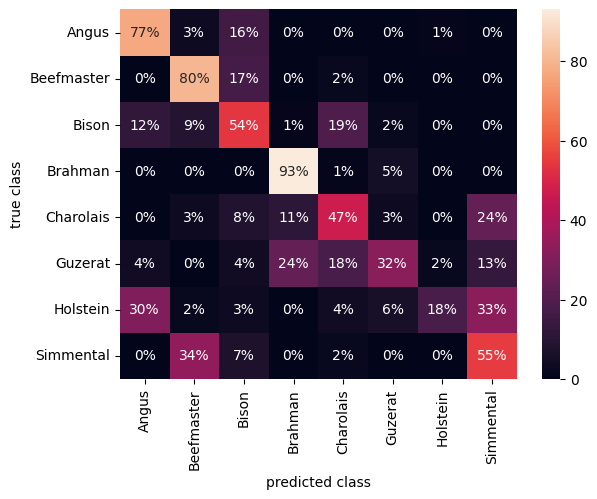

In [25]:
#Confusion matrix

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


df_cm = pd.DataFrame(cm)
df_cm= df_cm.astype(int)
df_cm.index = classes
df_cm.columns = classes

# Calcula los porcentajes en la matriz de confusión
df_cm_pct = df_cm.apply(lambda x: x / x.sum() * 100, axis=1)

# Configura el formato de los valores en la matriz de confusión
df_cm_pct = df_cm_pct.astype(int)

# Configura los valores de las anotaciones en porcentaje con el signo %
annot_values = df_cm_pct.astype(str) + '%'

# Grafica la matriz de confusión en forma de heatmap con el signo %
sn.heatmap(df_cm_pct, annot=annot_values, fmt='', annot_kws={"fontsize": 10})
plt.ylabel('true class')
plt.xlabel('predicted class')
plt.show()

ROC AUC score: 0.7558907603250962


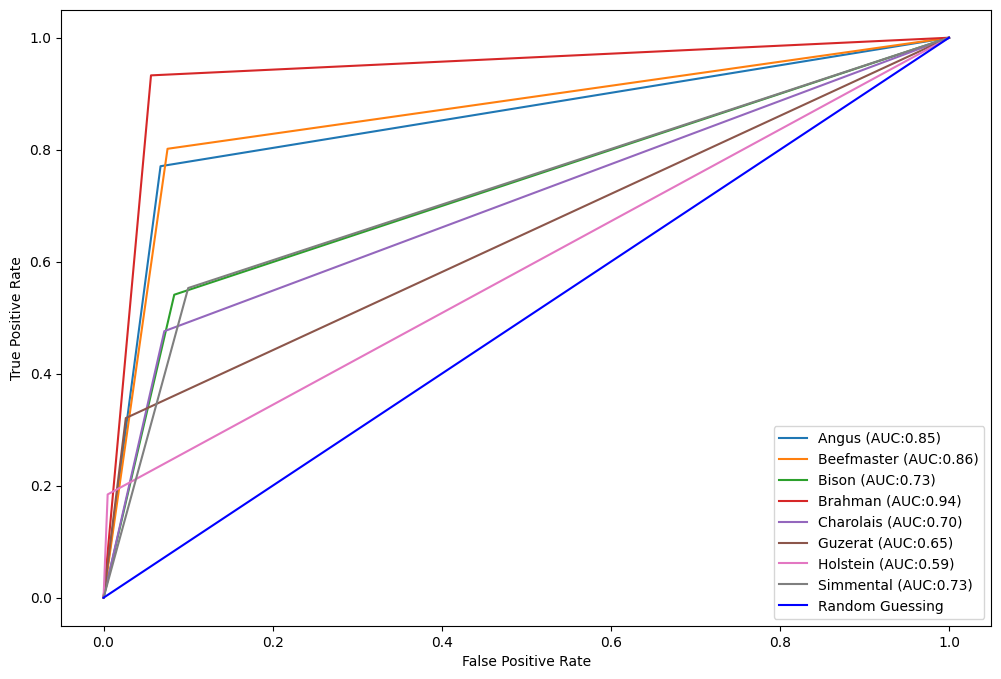

In [26]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import f1_score,confusion_matrix, balanced_accuracy_score, roc_curve, roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay, auc
import seaborn as sns
import numpy as np
from pylab import savefig
from scipy import interp
from itertools import cycle

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    target = classes
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

print('ROC AUC score:', multiclass_roc_auc_score(y_true, y_pred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()


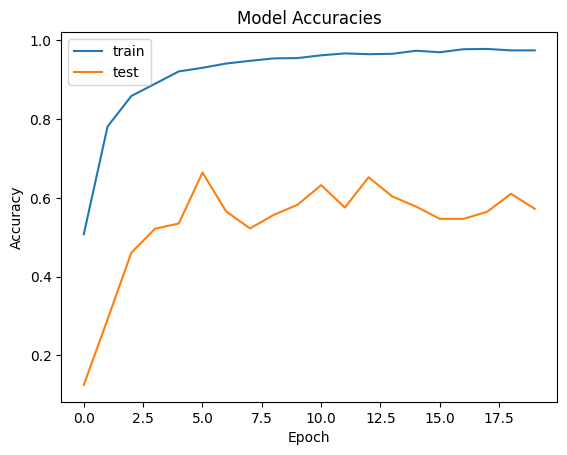

In [27]:
#showing accuracy over epochs

import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracies')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

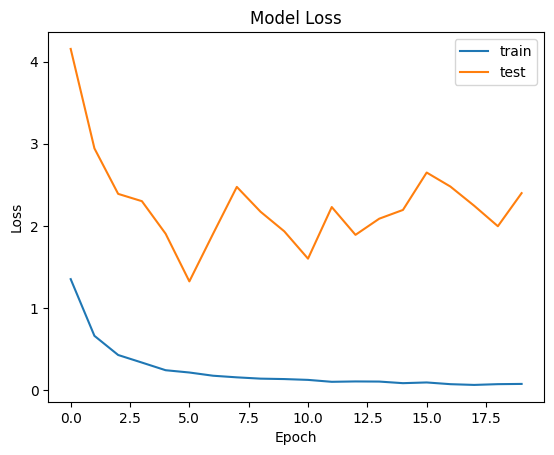

In [28]:
#showing loss over epochs

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

1/1 [==============================] - 0s 18ms/step


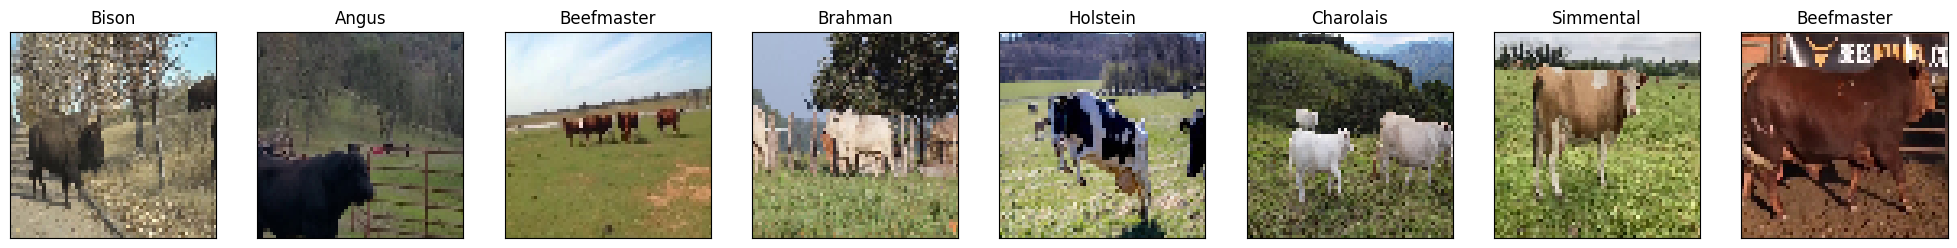

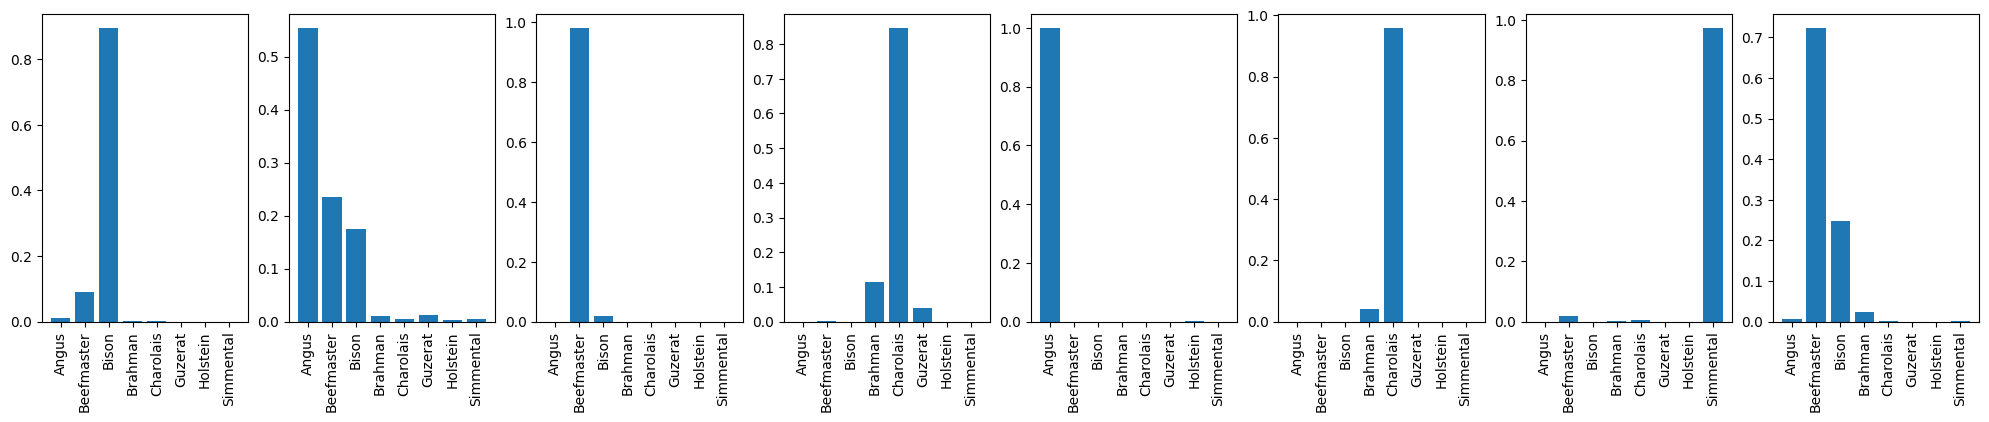

In [31]:
import random

# Obtener índices aleatorios para las imágenes de validación
indices = random.sample(range(valid_generator[0][0].shape[0]), 8)

fig = plt.figure(figsize=(25, 10))
for i, idx in enumerate(indices):
    plt.subplot(1, 8, i + 1)
    img = valid_generator[0][0][idx]
    plt.imshow(img.reshape(64, 64, 3))
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img)[0]
    plt.xticks([])
    plt.yticks([])
    plt.title(classes[int(valid_generator[0][1][idx])])

fig = plt.figure(figsize=(25, 4))
for i, idx in enumerate(indices):
    plt.subplot(1, 8, i + 1)
    img = valid_generator[0][0][idx]
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img)[0]
    prob = {i: j for i, j in zip(classes, list(pred))}
    plt.bar(prob.keys(), prob.values())
    plt.xticks(rotation='vertical')

plt.show()
